In [1]:
from __future__ import annotations

from qamsi.strategies.scaling.volatility_targeting import VolatilityTargeting
from qamsi.strategies.heuristics.equally_weighted import EWStrategy
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.utils.data import read_csv
from run import Dataset

REBAL_FREQ = "ME"
TOP_N = 30
DATASET = Dataset.TOPN_US
ESTIMATOR = CovEstimators.DNK.value(shrinkage_type="linear")
BASELINE = EWStrategy()

In [2]:
strategy_name = DATASET.name + ESTIMATOR.__class__.__name__ + f"_rebal{REBAL_FREQ}"
baseline_name = DATASET.name + BASELINE.__class__.__name__ + f"_rebal{REBAL_FREQ}"

strategy = read_csv(DATASET.value(topn=TOP_N).SAVE_PATH, strategy_name + ".csv")
baseline = read_csv(DATASET.value(topn=TOP_N).SAVE_PATH, baseline_name + ".csv")

In [3]:
strategy_excess_r = strategy["strategy_xs_r"]
baseline_excess_r = baseline["strategy_xs_r"]
rf = strategy["acc_rate"]

In [4]:
rebal_dates = strategy["rebal"]
rebal_dates = rebal_dates[rebal_dates].index

In [5]:
vol_scaler = VolatilityTargeting(
    trading_lag=1,
    max_exposure=2,
)
scaled_strategy_total_r = vol_scaler(
    strategy_excess_r=strategy_excess_r,
    rebal_dates=rebal_dates,
    baseline=baseline_excess_r,
).add(rf, axis=0)

In [6]:
from qamsi.backtest.assessor import Assessor

assessor = Assessor(
    rf_rate=rf,
    factors=strategy[
        strategy.columns.difference(["strategy_xs_r", "rebal", "acc_rate"])
    ],
)

In [7]:
assessor(scaled_strategy_total_r)

StrategyStatistics:
* final_nav = 20.328568
* geom_avg_total_r = 0.171659
* geom_avg_xs_r = 0.152362
* std_xs_r = 0.224501
* min_xs_r = -0.125640
* max_xs_r = 0.203797
* skew = 0.421105
* kurtosis = 23.128255
* max_dd = -0.479750
* sharpe = 0.678670
* alpha_buy_hold = 0.081774
* tracking_error_buy_hold = 0.152682
* ir_buy_hold = 0.535585
* factor_loadings = {'low_risk': 0.7846341142811993, 'momentum': -0.12916297547709266, 'quality': 0.19700413680360418, 'size': 0.03648377719660312, 'spx': 1.1106955810626211, 'value': -0.29459073569245076}
* alpha_benchmark = 0.051843
* alpha_benchmark_pvalue = 0.067261
* tracking_error_benchmark = 0.126187
* ir_benchmark = 0.410841
* ttest_pval = 0.148718
* levene_pval = 0.113233
* timing_ability_coef = -0.008252
* timing_ability_pval = 0.724478

In [8]:
assessor(baseline_excess_r + rf)

StrategyStatistics:
* final_nav = 6.285628
* geom_avg_total_r = 0.101514
* geom_avg_xs_r = 0.082217
* std_xs_r = 0.226559
* min_xs_r = -0.122205
* max_xs_r = 0.127455
* skew = -0.241644
* kurtosis = 10.460132
* max_dd = -0.604276
* sharpe = 0.362895
* alpha_buy_hold = 0.011629
* tracking_error_buy_hold = 0.045259
* ir_buy_hold = 0.256944
* factor_loadings = {'low_risk': -0.2920202932906375, 'momentum': 0.06438236302866211, 'quality': 0.02226121927403896, 'size': 0.027401459618944312, 'spx': 0.9264746534611608, 'value': 0.14664635585899263}
* alpha_benchmark = 0.017651
* alpha_benchmark_pvalue = 0.048284
* tracking_error_benchmark = 0.037069
* ir_benchmark = 0.476178
* ttest_pval = 0.427237
* levene_pval = 0.004384
* timing_ability_coef = -0.024532
* timing_ability_pval = 0.000622

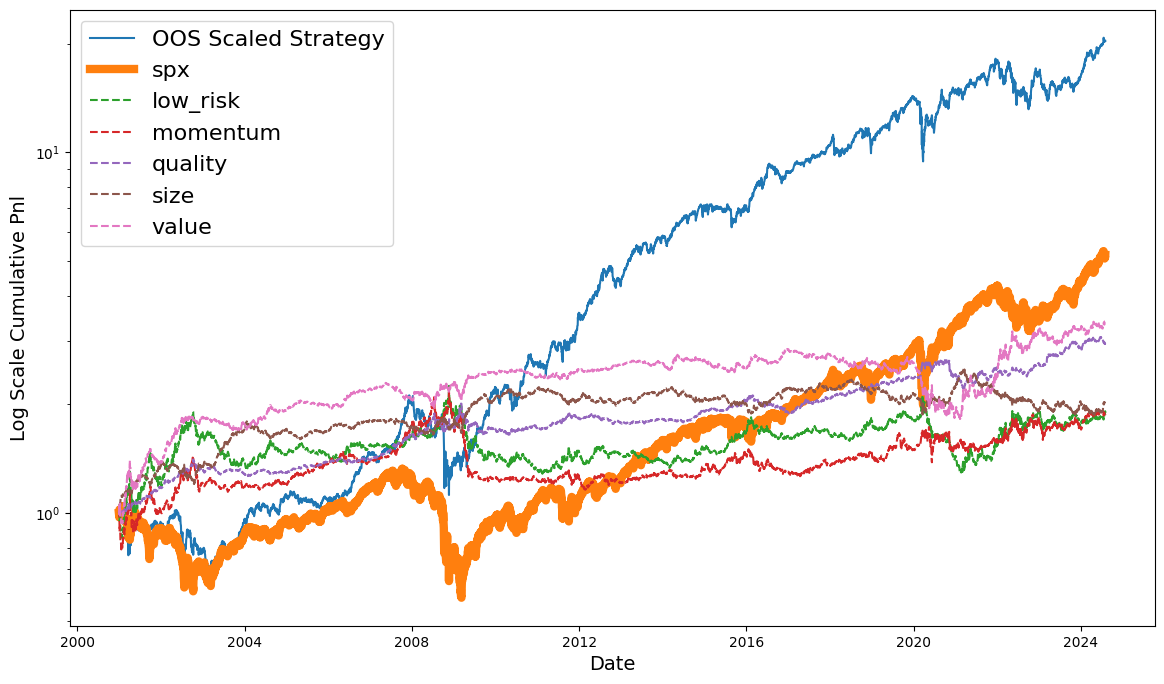

In [9]:
from qamsi.backtest.plot import plot_cumulative_pnls

plot_cumulative_pnls(
    strategy_total=scaled_strategy_total_r.to_frame("OOS Scaled Strategy"),
    buy_hold=strategy[
        strategy.columns.difference(["strategy_xs_r", "rebal", "acc_rate"])
    ].add(rf, axis=0),
    plot_log=True,
    name_strategy="OOS Scaled Strategy",
    mkt_name="spx",
)